In [459]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split

In [460]:
with open('names.txt','r') as w:
    names = w.read()
    names = names.splitlines()

In [461]:
len(names)

32033

In [462]:
torch.manual_seed(42)

In [463]:
chars = sorted(set(char for name in names for char in name))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
from typing import Any

def build_dataset(words:list[str],block_size=3):
    #context length / how many chars do we need to predict the next word
    x, y = [],[]

    for w in words:
        context = [0] * block_size

        for char in w + '.':
            ix = stoi[char]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]

    x = torch.tensor(x)
    y = torch.tensor(y)
    return x,y


def train_test_val_split(x:torch.Tensor, y:torch.Tensor, percent_train=0.7, percent_val=0.15)-> Any:
    n = len(x)
    
    # torch equivalent of permutation
    idxs = torch.randperm(n) #the best way to generate indices in random ordering
    
    n_train = int(n * percent_train)
    n_val   = int(n * percent_val)
    
    train_idx = idxs[:n_train]
    val_idx   = idxs[n_train:n_train+n_val]
    test_idx  = idxs[n_train+n_val:]
    
    return (x[train_idx], y[train_idx],
            x[test_idx], y[test_idx],
            x[val_idx], y[val_idx],train_idx)

In [475]:
x,y = build_dataset(names,8)

In [476]:
for x,y in zip(x[:20],y[:20]):
    print(''.join(itos[ix.item()] for ix in x),'-->',itos[y.item()] )

........ --> e
.......e --> m
......em --> m
.....emm --> a
....emma --> .
........ --> o
.......o --> l
......ol --> i
.....oli --> v
....oliv --> i
...olivi --> a
..olivia --> .
........ --> a
.......a --> v
......av --> a
.....ava --> .
........ --> i
.......i --> s
......is --> a
.....isa --> b


In [548]:
x,y = build_dataset(names)
print(len(x))
xtr,ytr,xtest,ytest,xval,yval,train_idx = train_test_val_split(x,y)
print(len(xtr),len(xtr)/len(x))

228146
159702 0.6999991233683693


In [562]:
from typing import Any


class Linear:

    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out))/fan_in**0.5 #kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x:torch.Tensor) -> Any:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out+= self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias] )
    
class BatchNorm1d:

    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # to allow our nueral network to move the gaussian around as per convenience
        self.gamma = torch.ones(dim) 
        self.beta = torch.zeros(dim)

        # running mean and variance that will be get a small update per batchs
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    # This is how u will call a batch-norm on a layer
    def __call__(self, x:torch.Tensor) -> Any:
        if self.training:
            xmean =  x.mean(0,keepdim=True)
            xvar = x.var(0,keepdim=True,unbiased=False)

        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            # if we're training, we update the mean and var per batch in an exponential moving average style.
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    
    def __call__(self,x:torch.Tensor) -> Any:
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class embed:
    # creating our embedding matrix so that each of the char can converted into n size embeddings
    # essentially each character a,b,c will be represented by a matrix that is learnable
    def __init__(self,n_embd,emb_dim):
        self.weight = torch.randn((n_embd,emb_dim))
    
    def __call__(self, IX:torch.Tensor) -> Any:
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class Flatten:
    #reshape our embedding layer so that we can matmul using compatible shapes
    def __call__(self,x:torch.Tensor):
        self.out = x.view(x.shape[0],-1)
        return self.out
    def parameters(self):
        return []

In [532]:
ix = torch.randint(0,27,(27,))
ix

tensor([25,  3,  8, 23, 10, 12, 11, 12, 16,  3, 24,  9, 17,  3,  6, 16,  8,  3,
         1, 20,  1, 14, 23,  9,  3, 23, 20])

In [533]:
itos[21]

'u'

In [534]:
x = embed(27,3)
C = x(ix)

In [536]:
C[21]

tensor([-1.2133,  0.9745,  0.4532])

In [539]:
C[stoi['u']]

tensor([-1.2133,  0.9745,  0.4532])

In [541]:
n_embd = 10
n_hidden = 200
vocab_size = len(stoi)
block_size = 3

C = torch.randn((vocab_size,n_embd))

layers = [
    Linear(n_embd*block_size,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size)]

with torch.no_grad():
    layers[-1].weight *= 0.1 #make softmax less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True

print(sum(p.numel() for p in parameters))

12097


In [549]:
z = torch.randint(0,20000,(32,))

In [565]:
x[9635].shape

torch.Size([3])

In [566]:
a = Flatten()
a(x[9635]).shape


torch.Size([3, 1])

In [558]:
C[x[9635]].view(-1)

tensor([-0.8791,  1.5491,  0.0154, -0.0276, -0.0537, -0.7734, -1.3838,  0.9782,
        -1.0310, -1.4264,  0.2686,  0.5349,  0.2829,  0.2560, -1.0973,  0.8444,
        -0.4120,  1.7921, -0.7673, -1.3080, -0.4629, -1.6246, -0.1852, -0.3435,
        -0.9828,  1.4724, -0.8553, -1.5335,  0.1289,  0.2891],
       grad_fn=<ViewBackward0>)

In [ ]:
max_steps = 200000
batch_size = 32

lossi = []

for i in range(max_steps):

    # forwards pass
    ix = torch.randint(0,xtr.shape[0],(batch_size,))
    xb , yb = xtr[ix], ytr[ix] # x and y of this batch
    emb = C[xb] #embed the x's

    # reshape emb so that is one long vector of 3's pairs
    x = emb.view(emb.shape[0],-1)
    
    for layer in layers:
        x = layer(x)
    

    loss = F.cross_entropy(x,yb)

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # loss tracking and logging
    if i%1000 == 0:
        print(f"{i:7d}/{max_steps:7d} : {loss.item():.4f}")
    lossi.append(loss.log10().item())
    


      0/ 200000 : 3.3008
   1000/ 200000 : 2.6147
   2000/ 200000 : 2.1808
   3000/ 200000 : 1.9745
   4000/ 200000 : 2.5328
   5000/ 200000 : 2.2018
   6000/ 200000 : 2.2158
   7000/ 200000 : 2.1342
   8000/ 200000 : 2.1109
   9000/ 200000 : 2.2559
  10000/ 200000 : 1.9384
  11000/ 200000 : 2.4166
  12000/ 200000 : 2.0260
  13000/ 200000 : 2.0473
  14000/ 200000 : 2.2703
  15000/ 200000 : 2.0166
  16000/ 200000 : 2.0946
  17000/ 200000 : 2.8566
  18000/ 200000 : 2.6870
  19000/ 200000 : 2.5936
  20000/ 200000 : 2.1607
  21000/ 200000 : 2.5791
  22000/ 200000 : 2.4159
  23000/ 200000 : 1.8262
  24000/ 200000 : 2.0463
  25000/ 200000 : 1.9648
  26000/ 200000 : 2.1545
  27000/ 200000 : 2.2416
  28000/ 200000 : 2.1003
  29000/ 200000 : 2.2928
  30000/ 200000 : 2.0351
  31000/ 200000 : 2.3542
  32000/ 200000 : 2.2865
  33000/ 200000 : 2.1010
  34000/ 200000 : 1.6417
  35000/ 200000 : 2.1609
  36000/ 200000 : 2.1641
  37000/ 200000 : 1.8390
  38000/ 200000 : 2.0597
  39000/ 200000 : 2.4833


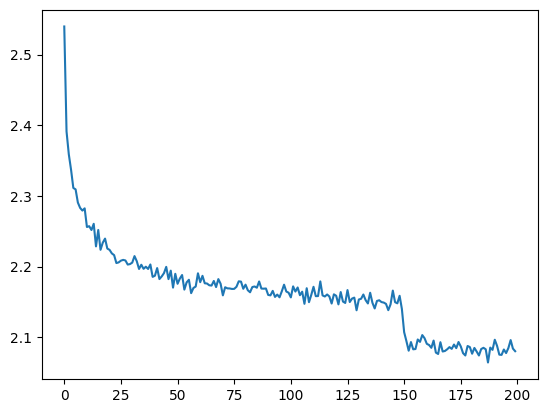

In [ ]:
x = torch.tensor(lossi).view(-1,1000)
x = 10**x #to unravel the Log10

plt.plot(x.mean(1,keepdim=True));

In [ ]:
# putting layers in eval mode
for layer in layers:
    layer.training = False

In [ ]:
# model evaluation
@torch.no_grad
def calc_loss(x,y,dataset:str):
    emb = C[x]
    x = emb.view(emb.shape[0],-1)

    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,y)
    print(f'{dataset} loss: {loss.item():.4f}')

calc_loss(xtr,ytr,'train')
calc_loss(xval,yval,'val')

train loss: 2.0541
val loss: 2.1087


In [ ]:
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        '''
        we convert each row into a probability matrix, and then do multinomial sampling from it, wherein each sample
        is a index of the invidiual item in the original row, which is most likely
        ''' 
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0],-1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = torch.softmax(logits,dim=1)
        # ----------------------
        ix = torch.multinomial(probs,num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break

    print(''.join(itos[i] for i in out))

kammieky.
aley.
caelyssonishiah.
midendeneas.
deckley.
skora.
styn.
ankita.
abrigilaiah.
cene.
els.
myrahnigh.
anni.
devilia.
prennosem.
lesilisley.
khalli.
ameecon.
bellah.
gabrider.
